# Calibrating & Using a $\pi$-pulse

Once we know the frequency of our qubit, the next step is to determine the strength of a $\pi$-pulse. The desired rotation is such that the qubit goes from $|0\rangle$ to $|1\rangle$. We will change the drive amplitude `amp` in small increments and measuring the state of the qubit each time. We expect to see oscillations which are commonly named Rabi oscillations, as the qubit goes between its computational subspaces.

In [2]:
import numpy as np
GHz = 1.0e9

qubit = 0
rough_qubit_frequency = 4.96227839460659 * GHz

In [13]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of_16(sec/dt)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Drive pulse parameters (us = microseconds)
drive_sigma_sec = 0.015 * us                           # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8               # This is a truncating parameter, because gaussians don't have 
                                                       # a natural finite length

Here we create a circuit to host our Rabi schedules

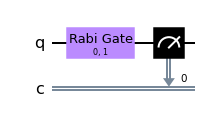

In [24]:
from qiskit import QuantumCircuit
from qiskit.circuit import Gate

rabi_circ = QuantumCircuit(1, 1)
calibrating_gate = Gate('Rabi Gate', 1, [0,1])
rabi_circ.append(calibrating_gate, [qubit])
rabi_circ.measure(0, 0)

rabi_circ.draw('mpl', idle_wires=False)

In [4]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')

backend_config = backend.configuration()
dt = backend_config.dt

In [5]:
inst_sched_map_man = backend.defaults().instruction_schedule_map

qubit = 0 # qubit 0 on ibmq_manila (there are 5 of them)
x_man = inst_sched_map_man.get('x', qubits=[qubit])

x_man.instructions

((0,
  Play(Drag(duration=160, amp=(0.19555861812669767+0j), sigma=40, beta=-0.5504508376305821, name='Xp_d0'), DriveChannel(0), name='Xp_d0')),)

In [25]:
# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

from qiskit.pulse import DriveChannel, Play, Schedule
from copy import deepcopy
from qiskit import pulse
from qiskit.pulse.library import Drag

rabi_circs = [] # array of rabi_circs

for amp_off in drive_amps:
    rabi_circ_off = deepcopy(rabi_circ)
    with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
        drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
        drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(rough_qubit_frequency, drive_chan)
        pulse.play(pulse.Gaussian(duration=drive_duration,
                                  amp=amp_off,
                                  sigma=drive_sigma,
                                  name='Rabi Pulse'), drive_chan)
    rabi_circ_off.add_calibration(calibrating_gate, [qubit], rabi_sched)
    rabi_circs.append(rabi_circ_off)

In [26]:
len(rabi_circs) # 50 circuits will be sent corresponding to 50 rabi scheds ~ 50 amplitude offset.

50

In [27]:
rabi_circs[0].draw()

┌────────────────┐┌─┐
q_0: ┤ Rabi Gate(0,1) ├┤M├
     └────────────────┘└╥┘
c: 1/═══════════════════╩═
                        0

In [28]:
from qiskit.tools.monitor import job_monitor

num_shots_per_amp = 1024

rabi_job = backend.run(rabi_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_amp)
job_monitor(rabi_job)
print(f"rabi oscillation job id: {rabi_job.job_id()}")

Job Status: job has successfully run
rabi oscillation job id: 6275df6d1d469e0e3560c696


In [30]:
rabi_results = rabi_job.result(timeout=120)
# rabi_results = backend.retrieve_job('6273f3459381703b163e72fc') 

In [35]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

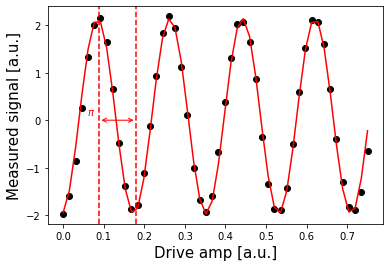

In [36]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

scale_factor = 1e-7
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [2, 0, 0.2, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [38]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.08929438196226828


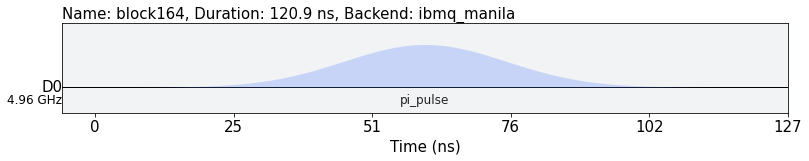

In [52]:
with pulse.build(backend) as pi_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)
pi_pulse.draw(backend=backend)

# Discriminating Computational Eigenstates

Our next job is going to be determining whether the receiving signals being $|0\rangle$ or $|1\rangle$.

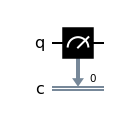

In [48]:
# Since we apply no pulse on the qubit, there's no need for calibration here.

gnd_circ = QuantumCircuit(1, 1)
gnd_circ.measure(0, 0)
gnd_circ.draw('mpl', idle_wires=False)

In [55]:
exc_circ = QuantumCircuit(1, 1)
exc_circ.x(0)
exc_circ.measure(0, 0)

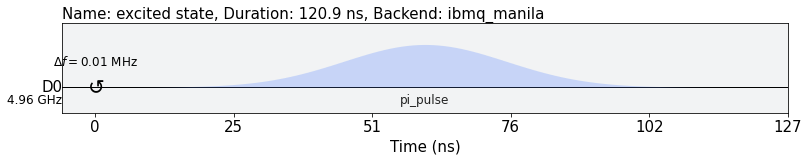

In [57]:
# Excited state schedule

with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse)
    
exc_circ.add_calibration('x', [qubit], exc_schedule)
exc_schedule.draw(backend=backend)

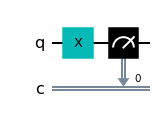

In [54]:
exc_circ.draw('mpl', idle_wires=False)

In [60]:
num_shots = 1024

job = backend.run([gnd_circ, exc_circ], 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)
job_monitor(job)
job.job_id()

Job Status: job has successfully run


'6275e95b5758cffba2c9aae8'

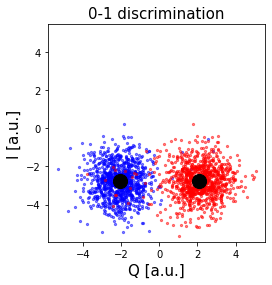

In [61]:
gnd_exc_results = job.result(timeout=120)

gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

plt.figure()

# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

plt.axis('square')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()

In [62]:
import math

def classify(point: complex):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))